In [1]:
import numpy as np
import cv2
import os
import sys
sys.path.insert(0,'./object_detection/bead_detection/lutils/')
sys.path.insert(1,'./object_detection/bead_detection/')
from data_utils import add_beads
import lutils
from tutils import nms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
possible_frames=['./object_detection/seed_frames/'+f for f in os.listdir('./object_detection/seed_frames/') if f.endswith('.jpg')]

In [3]:
frame=cv2.imread(np.random.choice(possible_frames),1)

In [4]:
threshold=0.6

In [5]:
beads_dir='./object_detection/templates/ox4/'
beads=[cv2.imread(beads_dir+f,1) for f in os.listdir(beads_dir)]

In [ ]:
#beads_added,locations=add_beads(frame,beads,10)

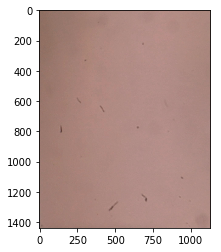

In [6]:
plt.imshow(frame)
plt.show()

In [7]:
def perturb_image(image,beads,initial_locations,n_perturbations=10):
    perturbed=[]
    for p in range(n_perturbations):
        _copy=image[:]
        xp,yp=[np.random.choice(2),np.random.choice(2)]
        new_locations=[]
        for (_x,_y,_,_) in initial_locations:
            new_locations.append((_x+xp,_y+yp))
            _t = np.random.choice(beads)
            _copy=lutils.add_bead_to_image(_copy, _t, _x+xp, _y+yp)
        perturbed.append((_copy,new_locations))
    return perturbed

In [15]:
_,initial_locations=add_beads(frame,beads,10)
perturbations=perturb_image(frame,beads,initial_locations,n_perturbations=1000)

In [16]:
template=cv2.cvtColor(beads[1],cv2.COLOR_BGR2GRAY)

In [37]:
true_values=[0,0]
measured_values=[0,0]

for img,pbts in perturbations:
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    res=cv2.matchTemplate(gray,template,cv2.TM_CCOEFF_NORMED)
    loc=[np.where(res>=threshold)[0],np.where(res>=threshold)[1],res[np.where(res>=threshold)]]
    loc=nms(loc)
    try:
        assert len(loc[0])>len(pbts),'Not enough candidates found'
        loc=zip(*loc)
        for idx,tb in enumerate(pbts):
            newloc=sorted(loc,key=lambda x: (x[0]-tb[0])**2+(x[1]-tb[1])**2,reverse=False)[0]
            measured=[newloc[0]-initial_locations[idx][0],newloc[1]-initial_locations[idx][1]]
            true=[tb[0]-initial_locations[idx][0],tb[1]-initial_locations[idx][1]]
            true_values[true[0]]+=1
            true_values[true[1]]+=1
            for m,t in zip(measured,true):
                if m>0 and t>0:
                    measured_values[1]+=1
                elif m==0 and t==0:
                    measured_values[0]+=1
    except:
        continue

In [28]:
np.mean(results)

0.0511

In [39]:
measured_values

[1507, 8058]

In [40]:
true_values

[9960, 10040]

In [42]:
print('Motion detection accuracy={:0.3f} %'.format(100*measured_values[1]/float(true_values[1])))

Motion detection accuracy=80.259 %


In [44]:
#print('Static detection accuracy={:0.3f} %'.format(100*measured_values[0]/float(true_values[0])))